#Health Fact Fake News Classification and Misinformation Detection using FLAN-T5 Model
## Project Development and Evaluation Summary

To evaluate and improve the health claim classification model, we conducted a series of benchmarking and fine-tuning experiments:

- **Benchmarking:** We first tested the baseline FLAN-T5 model on a set of 100 and 1,000 health claim samples to assess its initial classification accuracy on real-world statements.
  
- **Prompt Engineering:** To enhance model performance without retraining, we developed and refined prompt templates using 100 and 1,000 samples. This approach optimized the input formatting to guide the model toward more accurate classifications.

- **Fine-Tuning:** Building on prompt engineering, we fine-tuned the FLAN-T5 model with a labeled dataset of approximately 1,700 health claim samples. This process significantly improved the model’s ability to discern subtle misinformation and classify claims with higher precision.

- **User Interface:** Finally, we integrated the fine-tuned model into an interactive Gradio-based chatbot UI. This interface enables users to input health claims and receive real-time classification feedback, making the misinformation detection accessible and user-friendly.

These steps collectively enhanced the model’s reliability and usability in combating health misinformation effectively.


## Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download Required dependencies

In [2]:
!pip install pytorch-transformers
!pip install transformers
!pip install nltk
!pip install preprocessor
!pip install torch
!pip install sentencepiece
!pip install datasets
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
!pip install fsspec==2025.3.2

## Run dependencies

In [2]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import preprocessor as p
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

## Load Datasets

In [3]:
import pandas as pd

# Load datasets
train_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Cleaned_healthfact_traindata.json', lines=True)
val_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/cleaned_healthfact_dev.json', lines=True)
test_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/cleaned_healthfact_test.json', lines=True)

# Print number of rows
print(f"Number of rows in train dataset: {train_df.shape[0]}")
print(f"Number of rows in validation dataset: {val_df.shape[0]}")
print(f"Number of rows in test dataset: {test_df.shape[0]}")


Number of rows in train dataset: 9804
Number of rows in validation dataset: 1214
Number of rows in test dataset: 1233


The dataset for the Health Fact is very large, so in order to reduce training time and also minimize the RAM usage, we will be reducing the dataset.


## Reducing Health Fact Datasets
The reduced datasets have balanced classes (roughly equal number of True, False, and Misleading labels) which will help the model learn better and avoid bias toward overrepresented classes.

In [4]:
import json
import os
import random
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset directory
dataset_dir = '/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets'

# Define original dataset file names
train_filename = 'Cleaned_healthfact_traindata.json'
dev_filename = 'cleaned_healthfact_dev.json'
test_filename = 'cleaned_healthfact_test.json'

# Define new filenames for reduced datasets
reduced_train_filename = 'Reduced_HealthFact_Train.json'
reduced_dev_filename = 'Reduced_HealthFact_Dev.json'
reduced_test_filename = 'Reduced_HealthFact_Test.json'

# Function to save JSONL dataset
def save_jsonl(dataframe, filepath):
    dataframe.to_json(filepath, orient='records', lines=True, force_ascii=False)

# Load datasets with pandas
train_df = pd.read_json(os.path.join(dataset_dir, train_filename), lines=True)
val_df = pd.read_json(os.path.join(dataset_dir, dev_filename), lines=True)
test_df = pd.read_json(os.path.join(dataset_dir, test_filename), lines=True)

# Set the reduction sizes
train_size = 1000
dev_size = 500
test_size = 200

# Function for stratified sampling to get roughly equal number of samples per class
def stratified_sample(df, n_samples):
    classes = df['label'].unique()
    n_classes = len(classes)
    samples_per_class = n_samples // n_classes

    sampled_dfs = []
    for c in classes:
        class_subset = df[df['label'] == c]
        # Shuffle before sampling
        class_subset = class_subset.sample(frac=1, random_state=42).reset_index(drop=True)
        # Take min to avoid errors if class has fewer samples than requested
        n_take = min(samples_per_class, len(class_subset))
        sampled_dfs.append(class_subset.iloc[:n_take])

    # Combine all sampled dataframes
    stratified_df = pd.concat(sampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    return stratified_df

# Create stratified reduced datasets
reduced_train_df = stratified_sample(train_df, train_size)
reduced_dev_df = stratified_sample(val_df, dev_size)
reduced_test_df = stratified_sample(test_df, test_size)

# Save the reduced datasets with new names
save_jsonl(reduced_train_df, os.path.join(dataset_dir, reduced_train_filename))
save_jsonl(reduced_dev_df, os.path.join(dataset_dir, reduced_dev_filename))
save_jsonl(reduced_test_df, os.path.join(dataset_dir, reduced_test_filename))

# Print confirmation and label distribution for sanity check
print(f"Reduced datasets saved successfully!")
print(f"Train (Reduced): {len(reduced_train_df)} entries")
print(reduced_train_df['label'].value_counts())
print(f"Dev (Reduced): {len(reduced_dev_df)} entries")
print(reduced_dev_df['label'].value_counts())
print(f"Test (Reduced): {len(reduced_test_df)} entries")
print(reduced_test_df['label'].value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reduced datasets saved successfully!
Train (Reduced): 999 entries
label
MISLEADING    333
true          333
false         333
Name: count, dtype: int64
Dev (Reduced): 498 entries
label
false         166
MISLEADING    166
true          166
Name: count, dtype: int64
Test (Reduced): 198 entries
label
false         66
true          66
MISLEADING    66
Name: count, dtype: int64


## create a 100-sample benchmark set for Health Fact

In [18]:
import pandas as pd

# Load reduced Health Fact datasets
train_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Train.json', lines=True)
val_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Dev.json', lines=True)
test_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Test.json', lines=True)

# Function to do balanced stratified sampling
def stratified_sample(df, n_samples):
    classes = df['label'].unique()
    n_classes = len(classes)
    samples_per_class = n_samples // n_classes

    sampled_dfs = []
    for c in classes:
        class_subset = df[df['label'] == c]
        # Shuffle before sampling
        class_subset = class_subset.sample(frac=1, random_state=42).reset_index(drop=True)
        # Take min to avoid errors if class has fewer samples than requested
        n_take = min(samples_per_class, len(class_subset))
        sampled_dfs.append(class_subset.iloc[:n_take])

    # Combine and shuffle again
    stratified_df = pd.concat(sampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    return stratified_df

# Create a balanced 100-sample version of the training data
train_df_100 = stratified_sample(train_df, 100)

# Save it to your Google Drive
train_df_100.to_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Train_100.json', orient='records', lines=True)

# Print label distribution to check balance
print("Label distribution in 100-sample training subset:")
print(train_df_100['label'].value_counts())


Label distribution in 100-sample training subset:
label
true          33
false         33
MISLEADING    33
Name: count, dtype: int64


## Benchmarking with only 100 parameters

Benchmarking:   0%|          | 0/99 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Benchmarking: 100%|██████████| 99/99 [00:22<00:00,  4.49it/s]


Benchmark Accuracy: 51.52%

Confusion Matrix (Table Format):
                   Predicted True  Predicted False  Predicted Misleading
Actual True                    22               11                     0
Actual False                    4               29                     0
Actual Misleading               7               26                     0


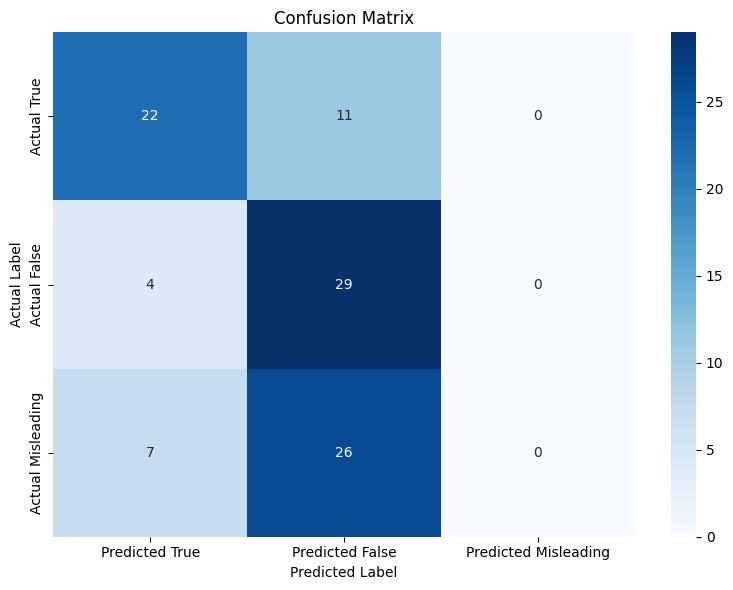


Classification Report:
              precision    recall  f1-score   support

        True       0.44      0.88      0.59        33
       False       0.00      0.00      0.00        33
  Misleading       0.67      0.67      0.67        33

    accuracy                           0.52        99
   macro avg       0.37      0.52      0.42        99
weighted avg       0.37      0.52      0.42        99



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Load the model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to("cuda")

# Function to classify the claim using the prompt
def classify_with_prompt(claim, explanation):
    prompt = (
        f"Classify this health-related claim as 'True', 'False', or 'Misleading' based on its veracity:\n"
        f"Claim: {claim}\n"
        f"Context: {explanation}\n"
        "Answer with just one word: 'True', 'False', or 'Misleading'"
    )

    # Tokenize the prompt and move inputs to GPU
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to("cuda")

    # Generate the prediction on GPU
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            temperature=0.7,
            num_beams=3
        )

    # Decode and normalize output
    result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()

    # Match to categories
    if any(word in result for word in ["true", "correct", "accurate"]):
        return "True"
    elif any(word in result for word in ["false", "incorrect", "inaccurate"]):
        return "False"
    elif any(word in result for word in ["misleading", "confusing", "unclear"]):
        return "Misleading"

    return "Unknown"


# Storage for results
predicted_labels = []
actual_labels = []
results = []

# Evaluation loop
correct = 0
total = 0

# Loop over the dataset with progress bar
for _, row in tqdm(train_df_100.iterrows(), total=len(train_df_100), desc="Benchmarking"):
    claim = row["claim"]
    explanation = row["explanation"]
    actual = str(row["label"]).lower().strip()

    # Get prediction from the model
    predicted = classify_with_prompt(claim, explanation)
    predicted = str(predicted).lower().strip()

    # Store results
    actual_labels.append(actual)
    predicted_labels.append(predicted)
    results.append({
        "claim_id": row["claim_id"],
        "predicted": predicted,
        "actual": actual
    })

    # Count correct predictions
    if predicted == actual:
        correct += 1
    total += 1

# Calculate and display accuracy
accuracy = correct / total
print(f"\nBenchmark Accuracy: {accuracy:.2%}")

# Confusion matrix setup
label_order = ["true", "false", "misleading"]
display_labels = ["True", "False", "Misleading"]

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=label_order)

# Create and print confusion matrix as DataFrame
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {label}" for label in display_labels],
                     columns=[f"Predicted {label}" for label in display_labels])
print("\nConfusion Matrix (Table Format):")
print(cm_df)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels, target_names=display_labels))


# Benchmarking with 1000 samples using Train_df dataset

Benchmarking:   0%|          | 0/999 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Benchmarking: 100%|██████████| 999/999 [03:42<00:00,  4.50it/s]


Benchmark Accuracy: 50.05%

Confusion Matrix (Table Format):
                   Predicted True  Predicted False  Predicted Misleading
Actual True                   204              129                     0
Actual False                   37              296                     0
Actual Misleading              89              244                     0


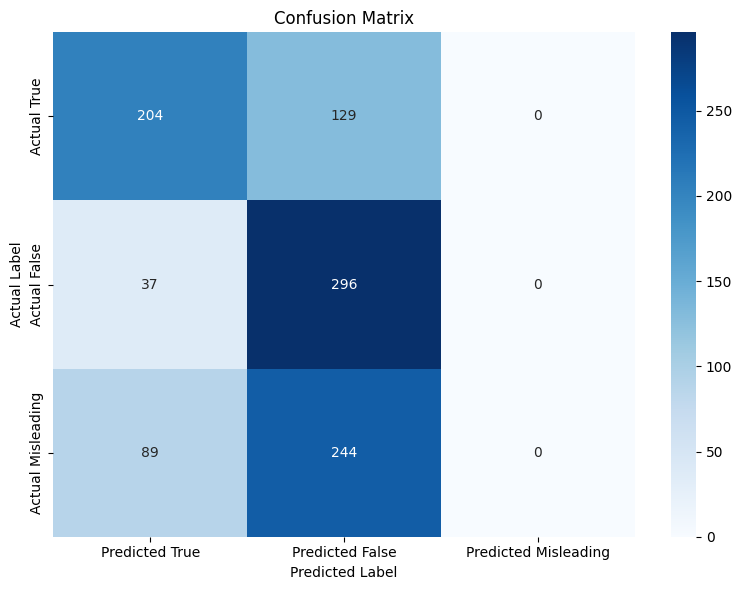


Classification Report:
              precision    recall  f1-score   support

        True       0.44      0.89      0.59       333
       False       0.00      0.00      0.00       333
  Misleading       0.62      0.61      0.62       333

    accuracy                           0.50       999
   macro avg       0.35      0.50      0.40       999
weighted avg       0.35      0.50      0.40       999



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torch

# Load tokenizer and model (on GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"  # Automatically use GPU if available
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)

# --- Helper function for classification ---
def classify_with_prompt(claim, explanation):
    prompt = (
        f"Classify this health-related claim as 'True', 'False', or 'Misleading' based on its veracity:\n"
        f"Claim: {claim}\n"
        f"Context: {explanation}\n"
        "Answer with just one word: 'True', 'False', or 'Misleading'"
    )

    # Tokenize input and run on GPU
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            temperature=0.7,
            num_beams=3
        )

    result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()

    # Clean prediction mapping
    if any(word in result for word in ["true", "correct", "accurate"]):
        return "True"
    elif any(word in result for word in ["false", "incorrect", "inaccurate"]):
        return "False"
    elif any(word in result for word in ["misleading", "confusing", "unclear"]):
        return "Misleading"
    return "Unknown"

# --- Benchmarking on 1000 samples ---
train_df_1000 = train_df.sample(n=999, random_state=42).reset_index(drop=True)

results = []
predicted_labels = []
actual_labels = []
correct = 0
total = 0

# Iterate through the 1000 samples with progress bar
for idx, row in tqdm(train_df_1000.iterrows(), total=len(train_df_1000), desc="Benchmarking"):
    predicted = classify_with_prompt(row["claim"], row["explanation"])
    actual = str(row["label"]).strip().lower()
    predicted = str(predicted).strip().lower()

    predicted_labels.append(predicted)
    actual_labels.append(actual)

    results.append({
        "claim_id": row["claim_id"],
        "predicted": predicted,
        "actual": actual
    })

    if predicted == actual:
        correct += 1
    total += 1

# --- Evaluation ---
accuracy = correct / total
print(f"\nBenchmark Accuracy: {accuracy:.2%}")

# Define labels
label_order = ["true", "false", "misleading"]
display_labels = ["True", "False", "Misleading"]

# Confusion Matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=label_order)
cm_df = pd.DataFrame(cm, index=[f"Actual {label}" for label in display_labels],
                         columns=[f"Predicted {label}" for label in display_labels])
print("\nConfusion Matrix (Table Format):")
print(cm_df)

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels, target_names=display_labels))


# Health Claim Classification prompt engineering 117 samples with FLAN-T5

This notebook uses the FLAN-T5 model to classify health-related claims as **True**, **False**, or **Misleading** based on the provided explanations.

## Key Steps:
1. **Model Initialization**: Load the `FLAN-T5` model and tokenizer.
2. **Text Cleaning**: Clean input text by removing special characters.
3. **Prompt Generation**: Create prompts for claim classification based on predefined rules.
4. **Classification**: Classify health claims using the model, with retry logic for robustness.
5. **Batch Processing**: Process claims in batches for efficiency.
6. **Evaluation**: Measure **accuracy**, **precision**, **recall**, **F1-score**, and average processing time.
7. **Results Saving**: Save classification results to a CSV file.

The results are then saved for further analysis.



Balanced label distribution:
 label
false         39
true          39
MISLEADING    39
Name: count, dtype: int64

Evaluating... Please wait...

[1/117] ✅ False (Actual: False, Time: 0.21s)
[2/117] ✅ True (Actual: True, Time: 0.17s)
[3/117] ✅ False (Actual: False, Time: 0.20s)
[4/117] ✅ True (Actual: False, Time: 0.16s)
[5/117] ✅ False (Actual: True, Time: 0.20s)
[6/117] ✅ True (Actual: Misleading, Time: 0.20s)
[7/117] ✅ False (Actual: False, Time: 0.20s)
[8/117] ✅ False (Actual: Misleading, Time: 0.20s)
[9/117] ✅ False (Actual: True, Time: 0.20s)
[10/117] ✅ False (Actual: True, Time: 0.21s)
[11/117] ✅ True (Actual: False, Time: 0.16s)
[12/117] ✅ False (Actual: True, Time: 0.20s)
[13/117] ✅ True (Actual: Misleading, Time: 0.20s)
[14/117] ✅ False (Actual: Misleading, Time: 0.20s)
[15/117] ✅ False (Actual: True, Time: 0.20s)
[16/117] ✅ False (Actual: True, Time: 0.20s)
[17/117] ✅ False (Actual: False, Time: 0.20s)
[18/117] ✅ False (Actual: Misleading, Time: 0.20s)
[19/117] ✅ True (Actual

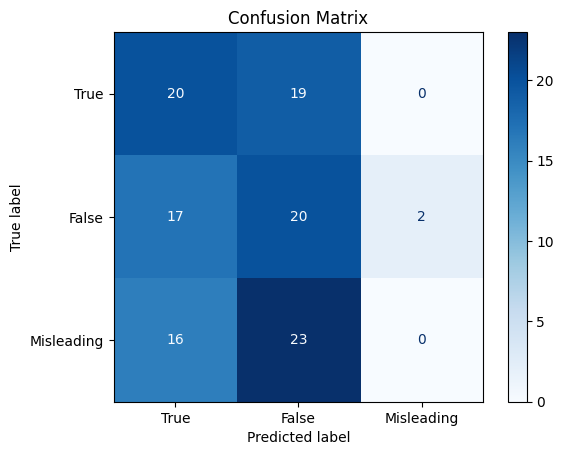


✅ All done. Results saved to:
/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Prompt_Engineering_results_health_fact_balanced_117_samples.csv


In [23]:
import re
import time
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)

# === Cleaning Function ===
def clean_text(text):
    return re.sub(r"[^a-zA-Z0-9\s.,!?]", "", str(text)).strip()

# === Prompt Generator ===
def generate_prompt(row):
    claim = clean_text(row['claim'])
    explanation = clean_text(row['explanation'])

    return f"""
You are a medical fact-checker AI.

Given a health claim and an explanation, classify the claim as one of:
- True (scientifically accurate),
- False (scientifically inaccurate or incorrect),
- Misleading (partially true or lacks strong evidence).

Claim: "{claim}"
Explanation: "{explanation}"
Answer only with: True, False, or Misleading.
""".strip()

# === Classification Function ===
def classify_with_prompt(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, padding="max_length", truncation=True).to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=5,
        do_sample=False,
        num_beams=3,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )
    raw_output = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    cleaned_output = raw_output.lower().strip().replace('"', '').replace("'", "").split()[0]  # Only first word

    if cleaned_output in ['true', 'false', 'misleading']:
        return cleaned_output.capitalize()
    return None  # Force retry if unexpected output

# === Main Classification with Retry ===
def classify_claim(row):
    prompt = generate_prompt(row)
    for attempt in range(3):
        try:
            response = classify_with_prompt(prompt)
            if response:
                return response
        except Exception as e:
            if attempt == 2:
                print(f"[ERROR] Failed to classify after retries: {e}")
        time.sleep(1)
    return "False"  # Default fallback if all retries fail

# === Evaluation Function ===
def evaluate_model(df):
    y_true, y_pred, durations, results = [], [], [], []

    print("\nEvaluating... Please wait...\n")

    for idx, row in df.iterrows():
        start = time.time()
        actual = str(row["label"]).strip().lower()
        predicted = classify_claim(row)
        end = time.time()

        y_true.append(actual)
        y_pred.append(predicted.lower())
        durations.append(end - start)

        results.append({
            "id": row.get("id", idx),
            "claim": row["claim"],
            "explanation": row["explanation"],
            "actual": actual.capitalize(),
            "predicted": predicted,
            "correct": predicted.lower() == actual,
            "time_sec": end - start
        })

        print(f"[{idx+1}/{len(df)}] ✅ {predicted} (Actual: {actual.capitalize()}, Time: {end - start:.2f}s)")

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("\n" + "="*60)
    print("🧪 EVALUATION RESULTS")
    print(f"✅ Accuracy:        {acc:.2%}")
    print(f"🎯 Precision (avg): {prec:.2%}")
    print(f"🔁 Recall (avg):    {rec:.2%}")
    print(f"📊 F1 Score (avg):  {f1:.2%}")
    print(f"⏱️ Avg Time/Claim:  {sum(durations)/len(durations):.2f} sec")
    print("="*60)

    # Confusion Matrix
    labels = ['true', 'false', 'misleading']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[l.capitalize() for l in labels])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    return pd.DataFrame(results)

# === Load and Balance Dataset ===
def load_and_balance_dataset(path, sample_size=100):
    df = pd.read_json(path, lines=True)

    # Sample the dataset to the sample_size, or use all if smaller
    sampled_df = df.sample(n=min(sample_size, len(df)), random_state=42)

    # Split into classes
    true_df = sampled_df[sampled_df['label'].str.lower() == 'true']
    false_df = sampled_df[sampled_df['label'].str.lower() == 'false']
    mis_df = sampled_df[sampled_df['label'].str.lower() == 'misleading']

    # Find max class size for upsampling
    max_size = max(len(true_df), len(false_df), len(mis_df))

    # Upsample all classes to max_size (with replacement) to balance
    true_up = resample(true_df, replace=True, n_samples=max_size, random_state=42)
    false_up = resample(false_df, replace=True, n_samples=max_size, random_state=42)
    mis_up = resample(mis_df, replace=True, n_samples=max_size, random_state=42)

    balanced_df = pd.concat([true_up, false_up, mis_up]).sample(frac=1, random_state=42).reset_index(drop=True)
    print("\nBalanced label distribution:\n", balanced_df['label'].value_counts())

    return balanced_df

# === Entry Point ===
if __name__ == "__main__":
    dataset_path = '/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Train.json'
    output_path = "/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Prompt_Engineering_results_health_fact_balanced_117_samples.csv"

    df_balanced = load_and_balance_dataset(dataset_path, sample_size=100)
    results_df = evaluate_model(df_balanced)

    results_df.to_csv(output_path, index=False)
    print(f"\n✅ All done. Results saved to:\n{output_path}")


# Health Claim Classification prompt engineering 1000 samples with FLAN-T5


Balanced label distribution:
 label
false         333
MISLEADING    333
true          333
Name: count, dtype: int64

Evaluating... Please wait...

[1/999] ✅ False (Actual: False, Time: 0.22s)
[2/999] ✅ True (Actual: Misleading, Time: 0.17s)
[3/999] ✅ True (Actual: True, Time: 0.21s)
[4/999] ✅ True (Actual: True, Time: 0.21s)
[5/999] ✅ False (Actual: Misleading, Time: 0.21s)
[6/999] ✅ False (Actual: False, Time: 0.20s)
[7/999] ✅ True (Actual: Misleading, Time: 0.16s)
[8/999] ✅ False (Actual: False, Time: 0.21s)
[9/999] ✅ True (Actual: False, Time: 0.16s)
[10/999] ✅ False (Actual: Misleading, Time: 0.20s)
[11/999] ✅ False (Actual: Misleading, Time: 0.22s)
[12/999] ✅ True (Actual: False, Time: 0.16s)
[13/999] ✅ False (Actual: Misleading, Time: 0.21s)
[14/999] ✅ True (Actual: False, Time: 0.16s)
[15/999] ✅ False (Actual: Misleading, Time: 0.20s)
[16/999] ✅ False (Actual: True, Time: 0.20s)
[17/999] ✅ True (Actual: Misleading, Time: 0.20s)
[18/999] ✅ True (Actual: False, Time: 0.20s)
[19/9

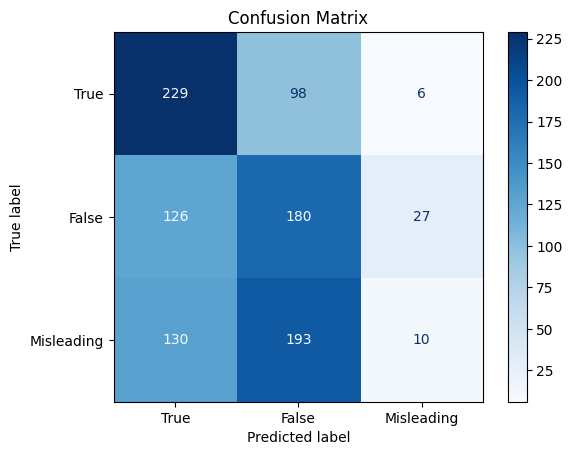


✅ All done. Results saved to:
/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Prompt_Engineering_results_health_fact_balanced_999_samples.csv


In [25]:
import re
import time
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)

# === Cleaning Function ===
def clean_text(text):
    return re.sub(r"[^a-zA-Z0-9\s.,!?]", "", str(text)).strip()

# === Prompt Generator ===
def generate_prompt(row):
    claim = clean_text(row['claim'])
    explanation = clean_text(row['explanation'])

    return f"""
You are a medical fact-checker AI.

Given a health claim and an explanation, classify the claim as one of:
- True (scientifically accurate),
- False (scientifically inaccurate or incorrect),
- Misleading (partially true or lacks strong evidence).

Claim: "{claim}"
Explanation: "{explanation}"
Answer only with: True, False, or Misleading.
""".strip()

# === Classification Function ===
def classify_with_prompt(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, padding="max_length", truncation=True).to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=5,
        do_sample=False,
        num_beams=3,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )
    raw_output = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    cleaned_output = raw_output.lower().strip().replace('"', '').replace("'", "").split()[0]  # Only first word

    if cleaned_output in ['true', 'false', 'misleading']:
        return cleaned_output.capitalize()
    return None  # Force retry if unexpected output

# === Main Classification with Retry ===
def classify_claim(row):
    prompt = generate_prompt(row)
    for attempt in range(3):
        try:
            response = classify_with_prompt(prompt)
            if response:
                return response
        except Exception as e:
            if attempt == 2:
                print(f"[ERROR] Failed to classify after retries: {e}")
        time.sleep(1)
    return "False"  # Default fallback if all retries fail

# === Evaluation Function ===
def evaluate_model(df):
    y_true, y_pred, durations, results = [], [], [], []

    print("\nEvaluating... Please wait...\n")

    for idx, row in df.iterrows():
        start = time.time()
        actual = str(row["label"]).strip().lower()
        predicted = classify_claim(row)
        end = time.time()

        y_true.append(actual)
        y_pred.append(predicted.lower())
        durations.append(end - start)

        results.append({
            "id": row.get("id", idx),
            "claim": row["claim"],
            "explanation": row["explanation"],
            "actual": actual.capitalize(),
            "predicted": predicted,
            "correct": predicted.lower() == actual,
            "time_sec": end - start
        })

        print(f"[{idx+1}/{len(df)}] ✅ {predicted} (Actual: {actual.capitalize()}, Time: {end - start:.2f}s)")

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("\n" + "="*60)
    print("🧪 EVALUATION RESULTS")
    print(f"✅ Accuracy:        {acc:.2%}")
    print(f"🎯 Precision (avg): {prec:.2%}")
    print(f"🔁 Recall (avg):    {rec:.2%}")
    print(f"📊 F1 Score (avg):  {f1:.2%}")
    print(f"⏱️ Avg Time/Claim:  {sum(durations)/len(durations):.2f} sec")
    print("="*60)

    # Confusion Matrix
    labels = ['true', 'false', 'misleading']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[l.capitalize() for l in labels])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    return pd.DataFrame(results)

# === Load and Balance Dataset ===
def load_and_balance_dataset(path, total_samples=999, per_class=333):
    df = pd.read_json(path, lines=True)

    # Filter for the three labels we want
    df = df[df['label'].str.lower().isin(['true', 'false', 'misleading'])]

    # Downsample or upsample each class to per_class size
    balanced_parts = []
    for label in ['true', 'false', 'misleading']:
        subset = df[df['label'].str.lower() == label]
        if len(subset) > per_class:
            # Downsample without replacement
            sampled = subset.sample(n=per_class, random_state=42)
        else:
            # Upsample with replacement
            sampled = resample(subset, replace=True, n_samples=per_class, random_state=42)
        balanced_parts.append(sampled)

    balanced_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nBalanced label distribution:\n", balanced_df['label'].value_counts())

    return balanced_df

# === Entry Point ===
if __name__ == "__main__":
    dataset_path = '/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Train.json'
    output_path = "/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Prompt_Engineering_results_health_fact_balanced_999_samples.csv"

    df_balanced = load_and_balance_dataset(dataset_path, total_samples=999, per_class=333)
    results_df = evaluate_model(df_balanced)

    results_df.to_csv(output_path, index=False)
    print(f"\n✅ All done. Results saved to:\n{output_path}")


# Moving On to Fine-Tuning!

In [26]:
!pip install matplotlib-venn
!pip install evaluate
!pip install bitsandbytes transformers peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 31.2 MB/s eta 0:00:00


In [27]:
!pip uninstall -y bitsandbytes
!pip install bitsandbytes==0.45.5
!pip install huggingface_hub[hf_xet]


Found existing installation: bitsandbytes 0.45.5
Uninstalling bitsandbytes-0.45.5:
  Successfully uninstalled bitsandbytes-0.45.5
  Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)


In [5]:
# ==========================================
# SECTION 1: Setup & Configuration
# ==========================================

import pandas as pd
import torch
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import Dataset

# Optional: wandb setup if you want logging
import wandb
wandb.login()

# Load datasets from Google Drive
train_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Train.json', lines=True)
val_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Dev.json', lines=True)
test_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health fact Cleaned Datasets/Reduced_HealthFact_Test.json', lines=True)

print("Sample from train dataset:", train_df.iloc[0])
print("Sample from val dataset:", val_df.iloc[0])
print("Sample from test dataset:", test_df.iloc[0])

wandb: Currently logged in as: joshylinnnnn (joshylinnnnn-deakin-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Sample from train dataset: claim_id                                                    9192
claim          Phase III COMPASS study with Bayer’s Rivaroxab...
explanation    This release touts the end of the biggest clin...
label                                                 MISLEADING
Name: 0, dtype: object
Sample from val dataset: claim_id                                                   17468
claim          People on pot "shoot each other ... stab each ...
explanation    Grace said, people on pot "shoot each other .....
label                                                      false
Name: 0, dtype: object
Sample from test dataset: claim_id                                                   26248
claim          “While California is dying … Gavin (Newsom) is...
explanation    Newsom has not been vacationing in Stevensvill...
label                                                      false
Name: 0, dtype: object


In [6]:
# ==========================================
# SECTION 2: Load Model & Tokenizer
# ==========================================

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

# Ensure padding token is set
tokenizer.pad_token = tokenizer.eos_token

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
# ==========================================
# SECTION 3: Prepare Dataset
# ==========================================

from datasets import Dataset

# Drop 'claim_id' column from pandas DataFrames
train_df = train_df.drop(columns=['claim_id'])
val_df = val_df.drop(columns=['claim_id'])
test_df = test_df.drop(columns=['claim_id'])

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Print a sample from each dataset before tokenization
print("Sample from train dataset before tokenization:", train_dataset[0])
print("Sample from validation dataset before tokenization:", val_dataset[0])
print("Sample from test dataset before tokenization:", test_dataset[0])

# Define the max length based on findings from your dataset
max_input_length = 512
max_target_length = 512

def tokenize_function(examples):
    # Prefix input text with instruction
    inputs = [f"Explain and verify this health claim: {x}" for x in examples["claim"]]
    targets = examples["explanation"]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )

    # Tokenize target/label
    with tokenizer.as_target_tokenizer():
        model_inputs["labels"] = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )["input_ids"]

    return model_inputs

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=val_dataset.column_names)
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=test_dataset.column_names)

# Print a sample from each dataset after tokenization
print("Sample from train dataset after tokenization:", train_dataset[0])
print("Sample from validation dataset after tokenization:", val_dataset[0])
print("Sample from test dataset after tokenization:", test_dataset[0])

Sample from train dataset before tokenization: {'claim': 'Phase III COMPASS study with Bayer’s Rivaroxaban in Patients with Coronary or Peripheral Artery Disease Shows Overwhelming Efficacy and Meets Primary Endpoint Early', 'explanation': 'This release touts the end of the biggest\xa0clinical trial to date on the drug Xarelto (rivaroxaban), used to prevent major adverse cardiac events such as heart attacks and strokes in people with coronary artery disease or peripheral artery disease. As we found with a recent release on the drug Repatha (which we also reviewed), this release does not provide findings from the study but instead acts more like a preview for the findings to be released at an upcoming scientific meeting. The release describes the study parameters (number enrolled, dosage, time frame, etc.) and discusses in clear detail the drug’s availability. But it left out potential harms from Xarelto and it also doesn’t cover the drug’s costs, talk about any of the specific benefits

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Sample from train dataset after tokenization: {'input_ids': [25488, 11, 10446, 48, 533, 1988, 10, 12559, 6289, 3, 6657, 30317, 810, 28, 2474, 49, 22, 7, 23878, 9, 12907, 9, 3478, 16, 18027, 28, 28045, 651, 42, 1276, 5082, 760, 138, 1261, 4203, 14326, 3111, 7, 2035, 210, 17757, 53, 3, 29421, 447, 4710, 11, 12325, 7, 14542, 3720, 2700, 8840, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [12]:
import logging
import torch
from transformers import (
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    TrainerCallback,
)
from sklearn.metrics import accuracy_score, f1_score

# ==============================
# SECTION 4: Define Training Setup
# ==============================

# Set up logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

class TrainingProgressCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            epoch = state.epoch
            train_loss = logs.get("loss")
            val_loss = logs.get("eval_loss")
            if train_loss is not None:
                logging.info(f"Epoch: {epoch:.2f}, Training Loss: {train_loss:.4f}")
            if val_loss is not None:
                # Use state.global_step instead of epoch for evaluation logging
                logging.info(f"Step: {state.global_step}, Validation Loss: {val_loss:.4f}")

import numpy as np

def compute_metrics(eval_preds):
    predictions, labels = eval_preds

    # Convert logits to predicted token IDs
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Get token IDs with argmax if predictions are logits
    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)

    # Replace -100 in labels with pad_token_id
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

    # Clip to vocab size to avoid out-of-range
    predictions = np.clip(predictions, 0, tokenizer.vocab_size - 1)
    labels = np.clip(labels, 0, tokenizer.vocab_size - 1)

    # Decode sequences
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Strip & lowercase for fair comparison
    decoded_preds = [pred.strip().lower() for pred in decoded_preds]
    decoded_labels = [label.strip().lower() for label in decoded_labels]

    if all(label == '' for label in decoded_labels):
        return {"accuracy": 0.0, "f1": 0.0}

    return {
        "accuracy": accuracy_score(decoded_labels, decoded_preds),
        "f1": f1_score(decoded_labels, decoded_preds, average="macro", zero_division=0),
    }


training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    run_name="Health_Fact_Fine_Tuning_Flan_T5",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    num_train_epochs=3,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=5e-5,
    max_grad_norm=1.0,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    predict_with_generate=True,
    fp16=True,
    fp16_full_eval=False,
    eval_accumulation_steps=4,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics,
    callbacks=[TrainingProgressCallback()],
)



<ipython-input-12-cc67802ba70a>:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [9]:
# ==========================================
# SECTION 5: Start Training
# ==========================================
torch.cuda.empty_cache()  # Clears cached memory

trainer.train()



`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Test set evaluation: {'eval_loss': nan, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_runtime': 203.9651, 'eval_samples_per_second': 0.971, 'eval_steps_per_second': 0.971, 'epoch': 2.960960960960961}


In [13]:
# Evaluate on test dataset after training
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test set evaluation:", test_results)

Test set evaluation: {'eval_loss': nan, 'eval_model_preparation_time': 0.0125, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_runtime': 203.9153, 'eval_samples_per_second': 0.971, 'eval_steps_per_second': 0.971}


In [14]:
import json
import os

# Define output directory in Google Drive
output_dir = "/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/finetuned_flan_t5_model"

os.makedirs(output_dir, exist_ok=True)

# Save test results
results_path = os.path.join(output_dir, "test_results.json")
with open(results_path, "w") as f:
    json.dump(test_results, f, indent=4)
print(f"Test results saved to {results_path}")

# Save fine-tuned model and tokenizer (this will overwrite the existing ones)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")


Test results saved to /content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/finetuned_flan_t5_model/test_results.json
Model and tokenizer saved to /content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/finetuned_flan_t5_model


In [15]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 134.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00


# UI ChatBot with Gradio

In [16]:
# ==========================================
# SECTION 1: Load the Model and Tokenizer
# ==========================================
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_dir = "/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/finetuned_flan_t5_model"

tokenizer = T5Tokenizer.from_pretrained(model_dir)
model = T5ForConditionalGeneration.from_pretrained(model_dir)


In [34]:
import torch
import gradio as gr

# Inference function same as before
def health_fact_chatbot(user_input):
    prompt = f"Classify the following health claim as 'True', 'False', or 'Misleading': {user_input}"

    inputs = tokenizer(prompt, return_tensors="pt", padding="longest", truncation=True).to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=256, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    return response

css = """
.chat-message.user {
    background: #a3d2ca; /* muted teal */
    color: #03312e;      /* dark teal text */
    border-radius: 15px 15px 0 15px;
    padding: 15px 20px;
    margin: 8px 0 8px 0;
    max-width: 70%;
    align-self: flex-end;
    animation: fadeIn 0.3s ease-in;
    position: relative;
    font-size: 1.4rem;  /* bigger font */
}

.chat-message.bot {
    background: #f0ead8;
    color: #000000;  /* pure black */
    border-radius: 15px 15px 15px 0;
    padding: 15px 20px;
    margin: 8px 0 8px 0;
    max-width: 70%;
    align-self: flex-start;
    animation: fadeIn 0.3s ease-in;
    position: relative;
    font-size: 1.4rem;  /* bigger font */
}

.message-sender {
    font-weight: bold;
    color: black; /* Black text for names */
    margin-bottom: 6px;
    font-size: 1.1rem; /* bigger */
}

.chat-container {
    display: flex;
    flex-direction: column;
    background: transparent;
}

@keyframes fadeIn {
    from {opacity: 0; transform: translateY(10px);}
    to {opacity: 1; transform: translateY(0);}
}

.gr-button {
    width: 100%;
    font-size: 1.25rem;  /* bigger buttons */
    padding: 12px 0;
}

#input-box textarea {
    font-size: 1.3rem; /* bigger input text */
    padding: 12px;
}

.usage-guidelines {
    font-size: 1.15rem;
    color: #333333;
    margin-bottom: 20px;
    max-width: 700px;
}

.gr-markdown {
    font-size: 1.15rem;
}

"""

with gr.Blocks(css=css) as demo:
    gr.Markdown("## Health Fact Verification")

    gr.Markdown(
        """
        <div class="usage-guidelines">
        **Usage Guidelines:**
        Enter clear health claims for classification as **True**, **False**, or **Misleading**.
        This tool is for informational purposes only and not a substitute for professional medical advice.
        Always verify important health information with trusted sources.
        </div>
        """
    )

    with gr.Row():
        claim_input = gr.Textbox(
            label="Enter a health claim",
            placeholder="Type your health claim here...",
            lines=2,
            max_lines=4,
            interactive=True,
            elem_id="input-box"
        )
        with gr.Column(scale=1, min_width=120):
            submit_btn = gr.Button("Submit", variant="primary")
            clear_btn = gr.Button("Clear", variant="secondary")
            examples = gr.Examples(
                examples=[
                    "Drinking warm water prevents COVID-19.",
                    "Exercise improves mental health.",
                    "Vaccines contain microchips for tracking.",
                    "Eating carrots improves night vision.",
                    "Using a sauna detoxifies your body.",
                    "Vitamin C cures the common cold.",
                    "5G technology spreads the coronavirus.",
                    "Sugar causes hyperactivity in children.",
                    "Cold weather causes colds.",
                    "Flu shots can give you the flu.",
                    "Wearing masks causes oxygen deficiency.",
                    "Homeopathy is an effective cancer treatment.",
                    "Antibiotics work against viruses.",
                    "Drinking bleach kills viruses.",
                    "COVID-19 vaccines alter your DNA."
                ],
                inputs=claim_input,
                label="Try some examples"
            )

    history_state = gr.State([])

    # Chatbox rendered with HTML and CSS
    chatbox = gr.HTML("<div class='chat-container' id='chatbox'></div>")

    response_output = gr.Textbox(visible=False)  # backend output

    def update_chatbox(history):
        html = "<div class='chat-container'>"
        for user_text, bot_text in history:
            html += f"""
            <div class='chat-message user'>
                <strong>🧑 You:</strong><br>{user_text}
            </div>
            <div class='chat-message bot'>
                <strong>🤖 Bot:</strong><br>{bot_text}
            </div>
            """
        html += "</div>"
        return html

    def on_submit(claim, history):
        response = health_fact_chatbot(claim)
        history.append((claim, response))
        chat_html = update_chatbox(history)
        return response, history, chat_html

    def on_clear():
        return "", [], "<div></div>"

    submit_btn.click(on_submit, inputs=[claim_input, history_state], outputs=[response_output, history_state, chatbox])
    clear_btn.click(on_clear, outputs=[claim_input, history_state, chatbox])

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://be3e9a035a39097735.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Pushing everything to GitHub

In [35]:
!git --version  # Check if git is installed (it usually is)


git version 2.34.1


Clone Company

In [36]:
!git clone https://github.com/DataBytes-Organisation/Fine-Tuning-LLMs-for-Enterprise-Applications.git

Cloning into 'Fine-Tuning-LLMs-for-Enterprise-Applications'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 193 (delta 45), reused 62 (delta 24), pack-reused 50 (from 1)
Receiving objects: 100% (193/193), 13.29 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [39]:
%cd Fine-Tuning-LLMs-for-Enterprise-Applications

/content/Fine-Tuning-LLMs-for-Enterprise-Applications


In [47]:
!git checkout YuChengJoshua_branch

Already on 'YuChengJoshua_branch'
Your branch is ahead of 'origin/YuChengJoshua_branch' by 6 commits.
  (use "git push" to publish your local commits)


In [44]:
!git pull origin YuChengJoshua_branch

From https://github.com/DataBytes-Organisation/Fine-Tuning-LLMs-for-Enterprise-Applications
 * branch            YuChengJoshua_branch -> FETCH_HEAD
Already up to date.


In [46]:
!git merge origin/main

Updating 54aa87e..449e8cc
Fast-forward
 Daniel Gan/Meta-Llama-3-8B                         |    1 +
 Daniel Gan/Mistral-7B-v0.1                         |    1 +
 Daniel Gan/Pre-fine tune Llama model .ipynb        | 1977 +++++++++++++++
 Daniel Gan/Pre-fine tune Mistral model.ipynb       | 2658 ++++++++++++++++++++
 .../compliance_llama_baseline_evaluation.docx      |  Bin 0 -> 42329 bytes
 Daniel Gan/compliance_llm_evaluation(test 1).docx  |  Bin 0 -> 38741 bytes
 .../compliance_mistral_baseline_evaluation.docx    |  Bin 0 -> 42118 bytes
 Daniel Gan/vllm                                    |    1 +
 8 files changed, 4638 insertions(+)
 create mode 160000 Daniel Gan/Meta-Llama-3-8B
 create mode 160000 Daniel Gan/Mistral-7B-v0.1
 create mode 100644 Daniel Gan/Pre-fine tune Llama model .ipynb
 create mode 100644 Daniel Gan/Pre-fine tune Mistral model.ipynb
 create mode 100644 Daniel Gan/compliance_llama_baseline_evaluation.docx
 create mode 100644 Daniel Gan/compliance_llm_evaluation(test 

In [48]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
cp "/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/HealthFact/Health Fact Fake News Classification and Misinformation Detection.ipynb" "/content/Fine-Tuning-LLMs-for-Enterprise-Applications/"


In [62]:
%cd /content/Fine-Tuning-LLMs-for-Enterprise-Applications

/content/Fine-Tuning-LLMs-for-Enterprise-Applications


In [63]:
!git add "Health Fact Fake News Classification and Misinformation Detection.ipynb"

In [65]:
!git config --global user.email "joshylinn@hotmail.com"
!git config --global user.name "Jo5hylinn"

In [66]:
!git commit -m "Add Health Fact Fake News Classification Model with Flan-T5 (Large)"

[YuChengJoshua_branch 5f4eef0] Add Health Fact Fake News Classification Model with Flan-T5 (Large)
 1 file changed, 1 insertion(+)
 create mode 100644 Health Fact Fake News Classification and Misinformation Detection.ipynb


In [67]:
!git push origin YuChengJoshua_branch

fatal: could not read Username for 'https://github.com': No such device or address
